In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score, mean_squared_error

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import re

from scipy.stats import kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols

from datetime import datetime
from time import time

In [98]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)

## 1. Business Understanding

As a frequent customer of Airbnb, 90% of my bookings are with Superhosts. I always wonder what type of property/hosts are more likely to be superhosts and what additional value this title bring to them?

According to Airbnb, 

'The four criteria that hosts must meet to become an Airbnb Superhost are:
  - Host a minimum of 10 stays in a year.
  - Respond to guests quickly and maintain a 90% response rate or higher.
  - Have at least 80% 5-star reviews.
  - Honor confirmed reservations (meaning hosts should rarely cancel)'

We can see that Airbnb has a strict criteria on who qualify as superhosts. Therefore, it would be interesting to understand the following through further analysis and modelling:

1. Are superhosts' properties more occupied (lower future occupancy) than non-superhosts'? 
   - For properties in the same neighbourhood and of similar size, how does availability and price compare?
2. Are superthosts' properties priced higher than non-superhosts?
3. Other than the superhost status (as a plausible factor), what are the top ten factors that affect occupancy (i.e. high future availability)?
   - Initial hypothesis is that newly listed properties with few reviews, or low ratings could adversely impact occupancy



## 2. Data Understanding

In this section, I will do some simple EDA to understand each dataset - the structure, level of detail, nulls and distribution of data.

In [99]:
def read_data(filename):
    
    '''
    Read CSV and print out shape, data types, number of nulls for each
    '''
    
    df = pd.read_csv(filename)
    
    num_entries = len(df)
    num_col = df.shape[1]
    col_type = df.dtypes
    col_null = df.isnull().sum()
    
    print('There are '+str(num_entries) +' entries')
    print('There are '+str(num_col) +' columns')
    print(' ')
    print('These are the data types --')
    print(col_type)
    print(' ')
    print('The columns have the following number of nulls')
    print(col_null)
    print(' ')
    print(' ')
    
    return df

##### Calendar data

In [100]:
sdf_cal = read_data('calendar.csv')
sdf_cal.head()

There are 1393570 entries
There are 4 columns
 
These are the data types --
listing_id     int64
date          object
available     object
price         object
dtype: object
 
The columns have the following number of nulls
listing_id         0
date               0
available          0
price         459028
dtype: int64
 
 


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


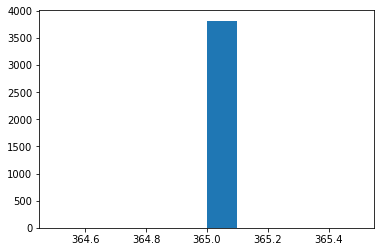

In [101]:
# How many days have the properties been listed? What is the distribution?
plt.hist(sdf_cal.groupby(['listing_id']).size())
plt.show()

Finding #1: Calendar dataframe shows future bookings one year onwards from 2016

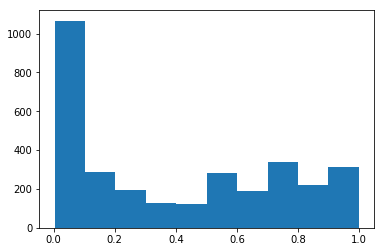

In [102]:
# What is the distribution of occupation rate of properties
plt.hist(sdf_cal[sdf_cal['available']=='f'].groupby(['listing_id']).size()/365)
plt.show()

Finding #2: Nearly a third of available stays (by night) in the next year are booked.

##### Listing data

In [103]:
sdf_list = read_data('listings.csv')
sdf_list.head()

There are 3818 entries
There are 92 columns
 
These are the data types --
id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
thumbnail_url                        object
medium_url                           object
picture_url                          object
xl_picture_url                       object
host_id                               int64
host_url                             object
host_name                            object
host_since                           object
host_location                        object
ho

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


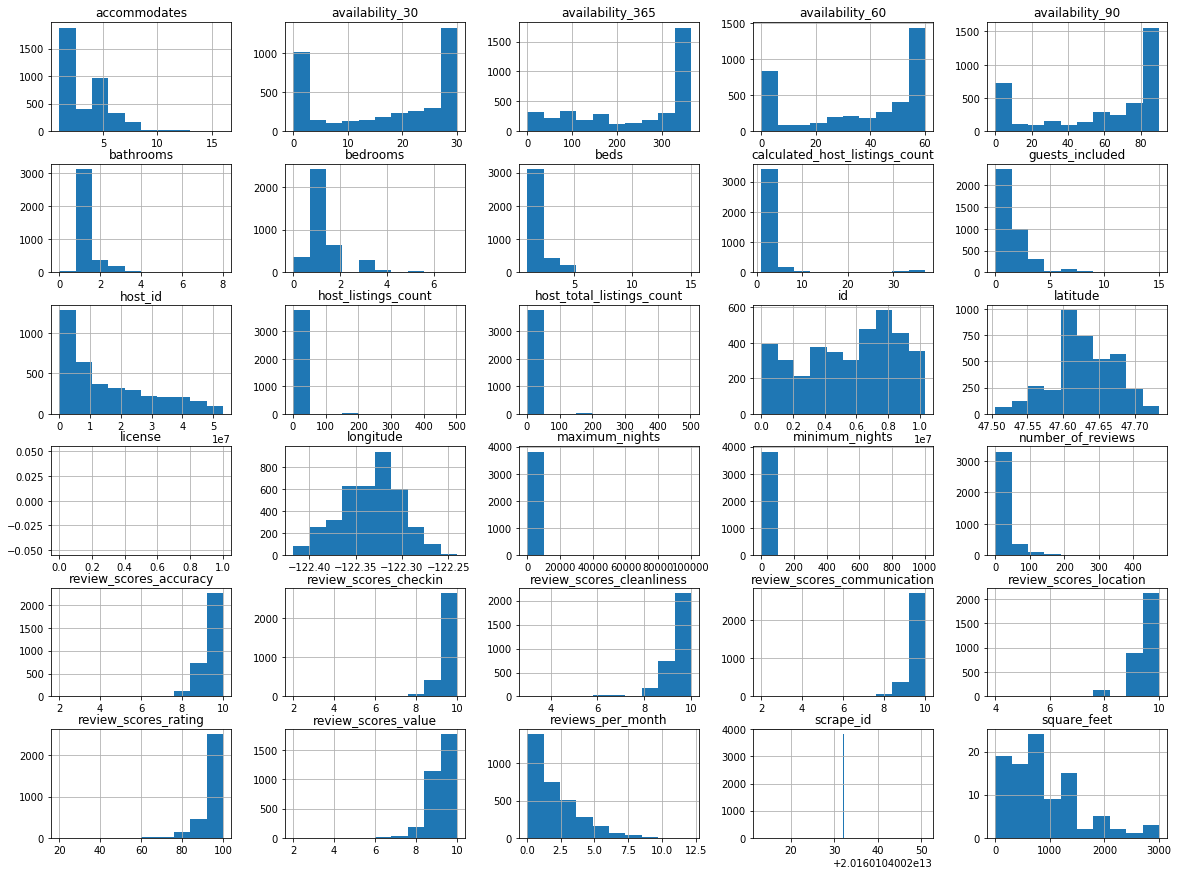

In [104]:
sdf_list.hist(figsize = (20,15))
plt.show()

Finding #3: Most airbnb's have fewer than three beds. 
There are extremes in the number of properties (for each type of property) with low and high occupancy in the future 90-day period. However, there are 

In [105]:
# What is the percentage of hosts who are superhosts?

(sdf_list['host_is_superhost'] == 't').sum()/ len(sdf_list)

0.2037716081718177

In [106]:
# What is the distribution of superhosts in different areas and different types of property?

def proportion_superhost(df, cat_col):
    '''
    Find out the proportion of superhosts in a particular segment of property
    
    INPUT:
    df - raw listing df
    cat_col - column that segments the listing into different categories
    OUTPUT:
    df_super - dataframe with 'perc' column outlining the % of listings that are superhosts
    '''
    
    list_super_neigh = df.groupby([cat_col,'host_is_superhost']).size().unstack()
    list_super_neigh['perc'] = list_super_neigh['t']/ (list_super_neigh['f'] + list_super_neigh['t'])
    df_super = list_super_neigh.sort_values(by = 'perc', ascending = False)
    
    plt.bar(df_super.index, df_super['perc'])
    plt.xticks(rotation = 'vertical')
    plt.show()
    return df_super

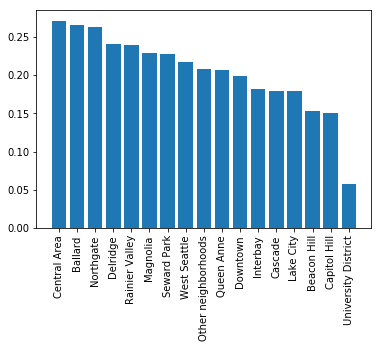

In [107]:
# Proportion of superhosts in different neighbourhoods
list_super_neigh = proportion_superhost(sdf_list, 'neighbourhood_group_cleansed')

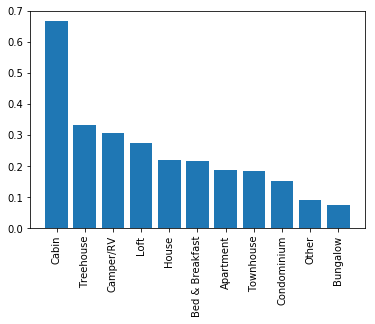

In [108]:
# Proportion of superhosts in different property types
list_super_proptype = proportion_superhost(sdf_list, 'property_type')

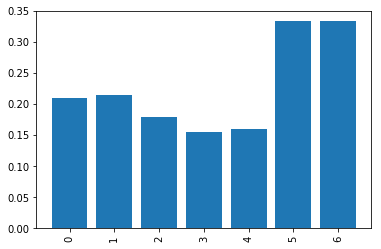

In [109]:
# Proportion of superhosts in different house sizes
list_super_bednum = proportion_superhost(sdf_list, 'bedrooms')

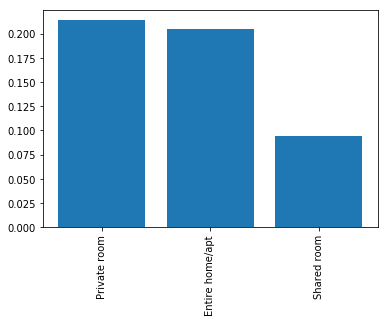

In [110]:
list_super_roomtype = proportion_superhost(sdf_list, 'room_type')

Finding #3: Around 20% of the listings are hosted by superhosts. 
- They have a particularly high representation in Central Area, Ballard, Northgate; and under-represented in University District, Capitol Hill and Beacon Hill.
- Less conventional property types like cabins, treehouse, camper/RVs have a higher proportion of superhosts, so does bigger properties (with six or more beds).

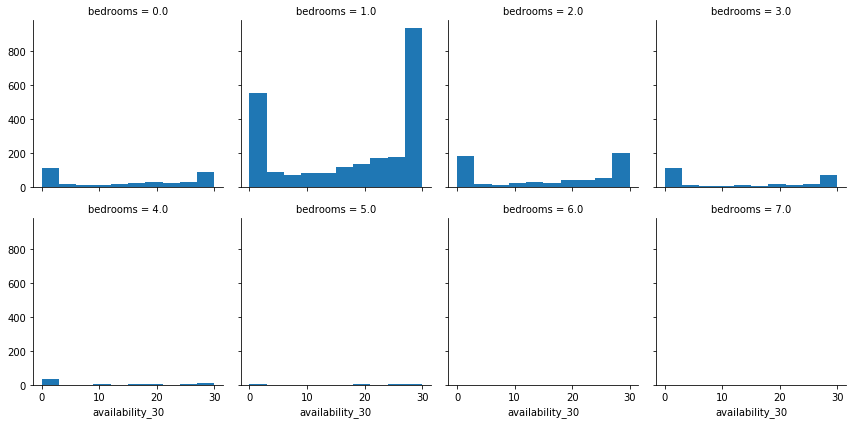

In [111]:
# What are the factors that impact availability?
# Which types of properties (# of rooms, # of bedrooms) have higher availability?

grid = sns.FacetGrid(sdf_list, col = "bedrooms", col_wrap = 4)
grid.map(plt.hist, "availability_30")

In [112]:
# Which variables vary proprotionately with review scores?
sdf_float = sdf_list.fillna(0).select_dtypes(include=['float64'])
sdf_float.corr()['review_scores_rating'].sort_values(ascending = False)

review_scores_rating           1.000000
review_scores_communication    0.985243
review_scores_cleanliness      0.982442
review_scores_value            0.981976
review_scores_accuracy         0.979406
review_scores_checkin          0.978234
review_scores_location         0.976161
reviews_per_month              0.432112
square_feet                    0.021942
beds                           0.014087
longitude                      0.008892
bathrooms                      0.007483
bedrooms                      -0.010024
latitude                      -0.019817
host_total_listings_count     -0.031702
host_listings_count           -0.031702
license                             NaN
Name: review_scores_rating, dtype: float64

Location and size of the place is less important to a rating, as compared to value, cleanliness and communication.

In [113]:
sdf_review = read_data('reviews.csv')
sdf_review.head()

There are 84849 entries
There are 6 columns
 
These are the data types --
listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object
 
The columns have the following number of nulls
listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64
 
 


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [114]:
# How many different guests has each listing hosted in the past year? (different from occupancy) 
# Number of reviews used as a proxy
sdf_review['year'] = sdf_review['date'].apply(lambda x: x[:4])
sdf_review_guests = sdf_review.groupby(['year', 'listing_id'])['reviewer_id'].nunique().sort_values(ascending = False)
sdf_review_guests[:20]

year  listing_id
2015  208356        140
      365550        139
2014  365550        136
2015  3861673       131
2014  794633        126
2015  794633        124
      2686374       120
      279063        115
2014  208356        114
2015  1279660       110
      3835995       109
      3487824       106
2014  841049        105
2015  5160893       105
2013  365550        104
2015  4598160       103
      3946160       101
      1758935       101
      5056580        98
2014  1758935        98
Name: reviewer_id, dtype: int64

Popular airbnb's can have more than 100 guest groups in a year. Also, we can see that some airbnbs have increase the number of stays year on year, whilst some have remain stagnant.

## 3. Data pre-processing

To continue the above analysis outlined in the business understanding section, only the listing data is required, as summarised calendar data and review data are contained in the listing data already. The following data cleaning processes are required:
- All data have to be rid of nulls and the dtypes are to be converted to the correct to numerical or string 
where necessary.
- feature engineering to make different types/ sizes of airbnb comparable

##### Listing data

In [115]:
def clean_listing(listing_df):
    '''
    Removing columns that are not used for analysis, changing data types and carrying out imputations
    '''
    
    # 1 - redundant columns to remove
    col_remove = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url','picture_url', 
    'xl_picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 
    'host_listings_count', 'host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_cleansed',
    'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
    'is_location_exact', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names',
    'calculated_host_listings_count', 'maximum_nights', 'calendar_updated', 'summary', 'space', 'description', 
    'notes', 'host_location', 'has_availability']
    df_removecol = listing_df.drop(col_remove, axis = 1)
    df_removecol = df_removecol.dropna(axis = 1, thresh = int(len(listing_df)*0.33))
    
    # 2 - Change data type
    df_dtype = df_removecol
    date_col = ['first_review', 'last_review', 'host_since']
    for col in date_col:
        df_dtype[col] = pd.to_datetime(df_dtype[col])
        
    float_col = ['host_response_rate', 'host_acceptance_rate']
    for col in float_col:
        df_dtype[col] = df_dtype[col].str.replace('%','')
        
    price_col = ['price', 'weekly_price', 'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee']
    for col in price_col:
        df_dtype[col] = df_dtype[col].str.replace('$','').str.replace(',','').astype('float')
    
    # 3 - Imputation
    # 3a - Impute with 0
    col_impzero = ['reviews_per_month', 'cleaning_fee']
    df_dtype[col_impzero] = df_dtype[col_impzero].fillna(0)
    
    # 3b - Impute with median
    col_impmedian = ['host_response_rate', 'host_acceptance_rate', 'review_scores_rating', 
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
    'review_scores_location', 'review_scores_value', 'bedrooms', 'bathrooms', 'beds']

    for col in col_impmedian:
        med_val = int(df_dtype[col].median())
        df_dtype[col] = df_dtype[col].fillna(med_val)
        
    # 3c - Impute with max
    col_impmax = ['first_review', 'last_review', 'host_since']
    for col in col_impmax:
        df_dtype[col] = df_dtype[col].fillna(df_dtype[col].max())
        
    # 3d - Impute with 1
    df_dtype['guests_included'] = df_dtype['guests_included'].replace(0, 1)
    df_dtype['host_total_listings_count'] = df_dtype['host_total_listings_count'].fillna(1)

    return df_dtype

In [116]:
sdf_list_clean = clean_listing(sdf_list)
sdf_list_clean.head()

,id,name,experiences_offered,neighborhood_overview,transit,host_id,host_since,host_about,host_response_time,host_response_rate,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,241032,Stylish Queen Anne Apartment,none,NaN,NaN,956883,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,96,...,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07
1,953595,Bright & Airy Queen Anne Apartment,none,"Queen Anne is a wonderful, truly functional vi...","Convenient bus stops are just down the block, ...",5177328,2013-02-21,Living east coast/left coast/overseas. Time i...,within an hour,98,...,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48
2,3308979,New Modern House-Amazing water view,none,Upper Queen Anne is a charming neighborhood fu...,A bus stop is just 2 blocks away. Easy bus a...,16708587,2014-06-12,i love living in Seattle. i grew up in the mi...,within a few hours,67,...,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,1.15
3,7421966,Queen Anne Chateau,none,NaN,NaN,9851441,2013-11-06,NaN,NaN,100,...,10.0,10.0,10.0,10.0,10.0,f,flexible,f,f,0.00
4,278830,Charming craftsman 3 bdm house,none,We are in the beautiful neighborhood of Queen ...,The nearest public transit bus (D Line) is 2 b...,1452570,2011-11-29,"Hi, I live in Seattle, Washington but I'm orig...",within an hour,100,...,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,0.89


In [117]:
sdf_list_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 54 columns):
id                                  3818 non-null int64
name                                3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
transit                             2884 non-null object
host_id                             3818 non-null int64
host_since                          3818 non-null datetime64[ns]
host_about                          2959 non-null object
host_response_time                  3295 non-null object
host_response_rate                  3818 non-null object
host_acceptance_rate                3818 non-null object
host_is_superhost                   3816 non-null object
host_total_listings_count           3818 non-null float64
host_verifications                  3818 non-null object
host_has_profile_pic                3816 non-null object
host_identity_verified         

In [118]:
def tokenize_fct(text):
    
    '''
    Tokenize by word, remove stop words, lemmatize all phrases in the dataframe
    
    INPUT:
    text
    
    OUTPUT:
    df - df with three new columns: one normalised, one tokenized, with stop words removed 
    '''

    new_text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    new_text = word_tokenize(new_text)

    sw_list = stopwords.words("english")
    #eng_words = set(nltk.corpus.words.words())
    new_text = [w for w in new_text if w not in sw_list]
    #new_text = [w for w in new_text if w in eng_words]
    
    output_text = []
    for (word, pos) in nltk.pos_tag(new_text):
        if pos[:2]== 'JJ' or pos[:2]=='VB':
            output_text.append(word)
    
    return output_text

In [119]:
def feature_eng(df):
    '''
    The following transformations are carried out on the input dataframe.
    One-hot encoding, calculating price per person and long stay discounts, 
    calculating length of duration for date variables, calculating number of amenities,
    and tfidf vectorization
    '''
    
    # 1 - one hot encode columns
    binary = ['experiences_offered', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
             'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
    categorical = ['host_response_time', 'property_type', 'room_type', 'bed_type', 'neighbourhood_group_cleansed', 
                  'cancellation_policy']
    filled_in = ['host_about', 'neighborhood_overview', 'transit']
    
    df_onehot = pd.get_dummies(df, drop_first = True, columns = binary)
    df_onehot = pd.get_dummies(df_onehot, columns = categorical)
    
    # Flag 1 if the following columns are not null
    for col in filled_in:
        df_onehot[col] = df_onehot[col].apply(lambda x:0 if pd.isnull(x) else 1)
        
    # 2 - calculate price per person
    df_onehot['price_per'] = df_onehot['price']/ df_onehot['guests_included']
    df_onehot['extra_price'] = df_onehot['extra_people'] / df_onehot['price']
    df_onehot['clean_price'] = df_onehot['cleaning_fee'] / df_onehot['price']
    df_onehot['security_price'] = df_onehot['security_deposit'] / df_onehot['price']
    
    # 3 - calculate weekly/ monthly discount
    df_onehot['weekly_disc'] = 1 - df_onehot['weekly_price']/ (7* df_onehot['price'])
    df_onehot['monthly_disc'] = 1 - df_onehot['monthly_price']/ (30* df_onehot['price'])
    
    df_onehot[['security_price','weekly_disc','monthly_disc']] = df_onehot[['security_price','weekly_disc','monthly_disc']].fillna(0)
    
    date_col = ['first_review', 'last_review', 'host_since']
    date_max = df['host_since'].max()
    for col in date_col:
        df_onehot[col] = (date_max-df_onehot[col]).dt.days
    
    # 4 - calculate length
    len_col = ['amenities', 'host_verifications']
    for col in len_col:
        df_onehot[col] = df_onehot[col].apply(lambda x:len(x.split(',')))
    
    # 5 - TFIDF vectorize
    tfidf_trans = TfidfVectorizer(tokenizer = tokenize_fct)
    name_tfidf = tfidf_trans.fit_transform(df_onehot['name']).toarray()
    tfidf_list = list(pd.Series(tfidf_trans.vocabulary_).sort_values(ascending = True).index)
    tfidf_df = pd.DataFrame(name_tfidf, columns = ['tfidf'+i for i in tfidf_list])
    
    df_final = df_onehot.join(tfidf_df)
    df_final = df_final.drop(['id', 'name', 'host_id', 'latitude', 'longitude', 'price', 'weekly_price', 
                   'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee', 
                   'guests_included'], axis = 1)
    
    return df_final

In [120]:
sdf_list_feat = feature_eng(sdf_list_clean)
sdf_list_feat.head()

,neighborhood_overview,transit,host_since,host_about,host_response_rate,host_acceptance_rate,host_total_listings_count,host_verifications,accommodates,bathrooms,...,tfidfwifi,tfidfwindowed,tfidfwinning,tfidfwonderful,tfidfwooded,tfidfworkroom,tfidfwparking,tfidfxmas,tfidfyellow,tfidfzen
0,0,0,1606,1,96,100,3.0,4,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1046,1,98,100,6.0,6,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,570,1,67,100,2.0,5,11,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,788,0,100,100,1.0,5,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1496,1,100,100,2.0,5,6,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
sdf_list_feat.dtypes

neighborhood_overview            int64
transit                          int64
host_since                       int64
host_about                       int64
host_response_rate              object
host_acceptance_rate            object
host_total_listings_count      float64
host_verifications               int64
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
amenities                        int64
minimum_nights                   int64
availability_30                  int64
availability_60                  int64
availability_90                  int64
availability_365                 int64
number_of_reviews                int64
first_review                     int64
last_review                      int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communicati

## 4. Analysis and Modelling

### Question 1. Are superhosts' properties more occupied (lower future occupancy) than non-superhosts'? For properties in the same neighbourhood and of similar size, how does availability compare?


For this question, box plots will be first plotted to visualise if there difference in past occupancy (potentially proxied by average number of monthly reviews, which is likely to be influenced by both occupancy and level of service), future availabilities (for both short and long term) for different types of flat (defined by # of bedrooms - size, room type - privacy, and neighbourhood). Then ANOVA will be conducted to further understand whether the variance in availability, if any, is statistically significant.

In [122]:
def plot_split(category_col, data_col):
    sns.catplot(x = category_col, y = data_col, hue = "host_is_superhost", 
            data = sdf_list_clean, kind = 'box',  aspect=15/8)
    plt.xticks(rotation=90)

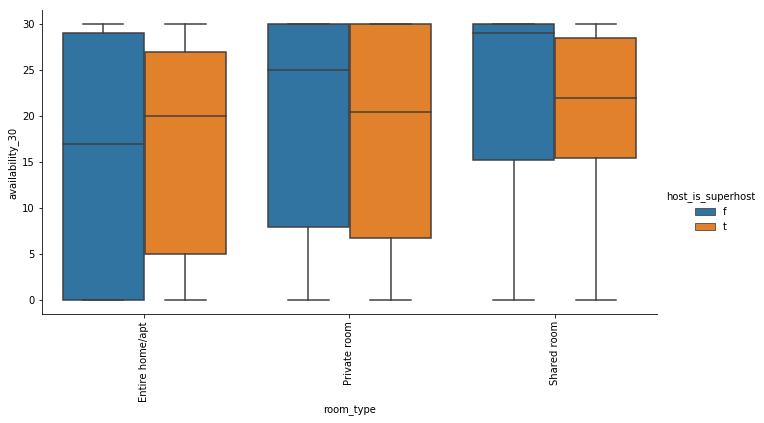

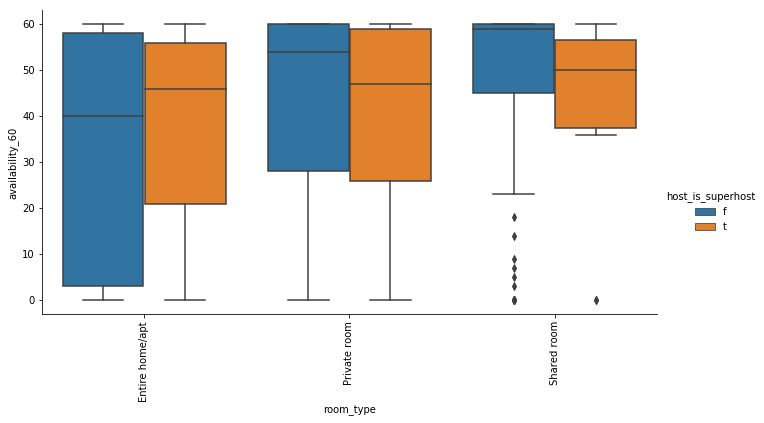

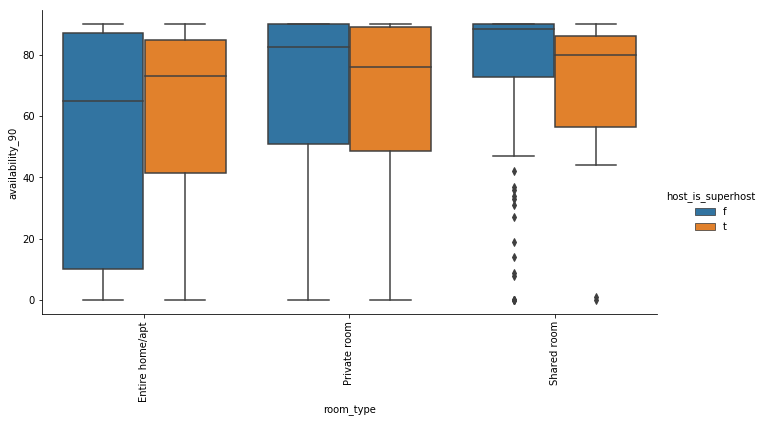

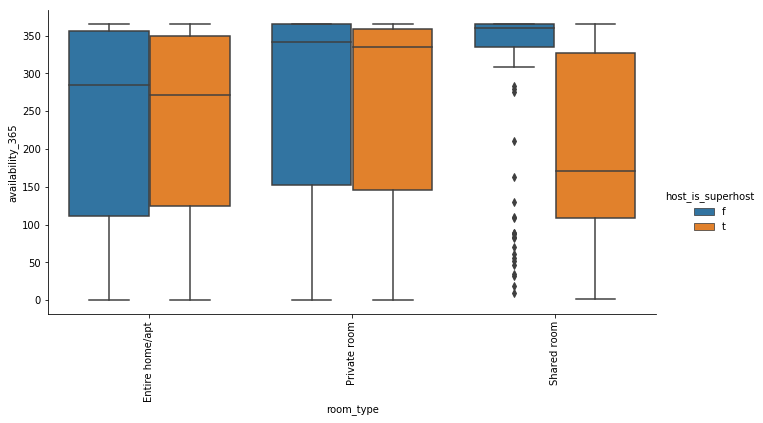

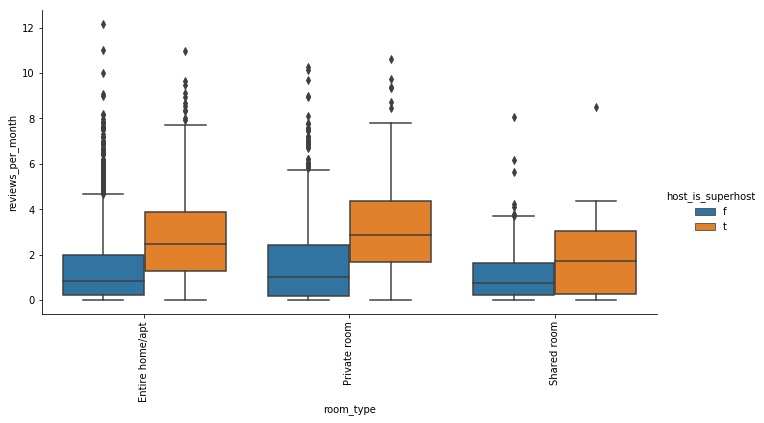

In [123]:
avail_col = ['availability_30', 'availability_60', 'availability_90', 'availability_365', 'reviews_per_month']

for col in avail_col:
    plot_split('room_type', col)

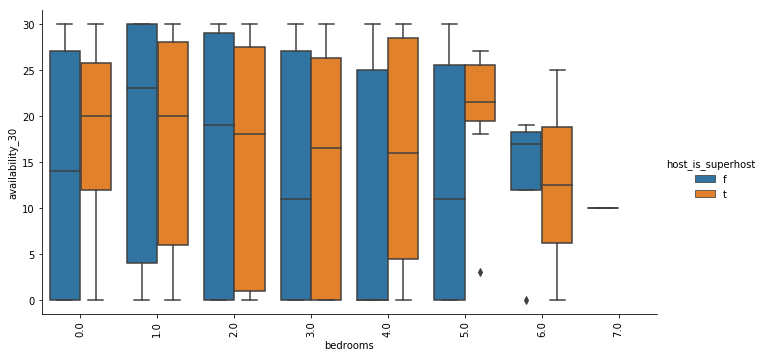

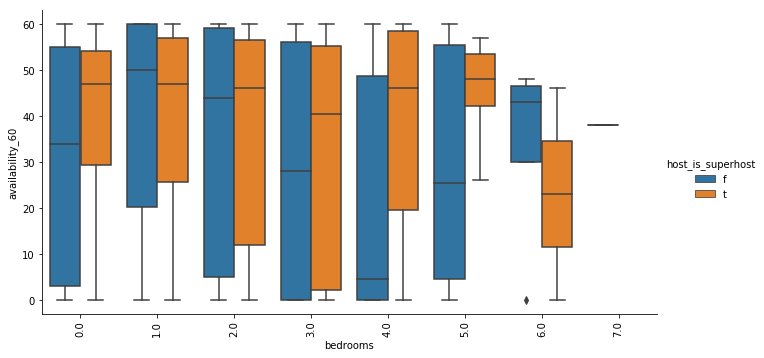

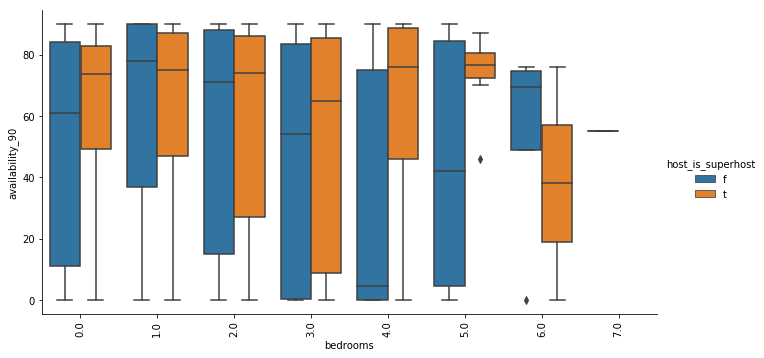

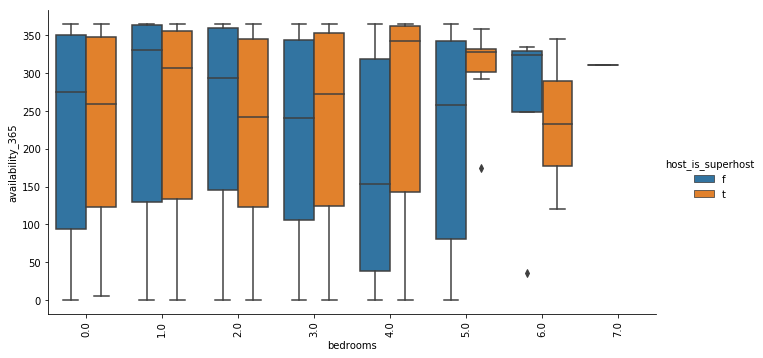

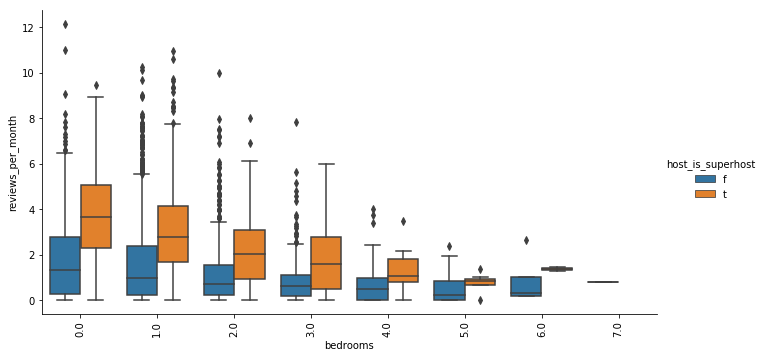

In [124]:
for col in avail_col:
    plot_split('bedrooms', col)

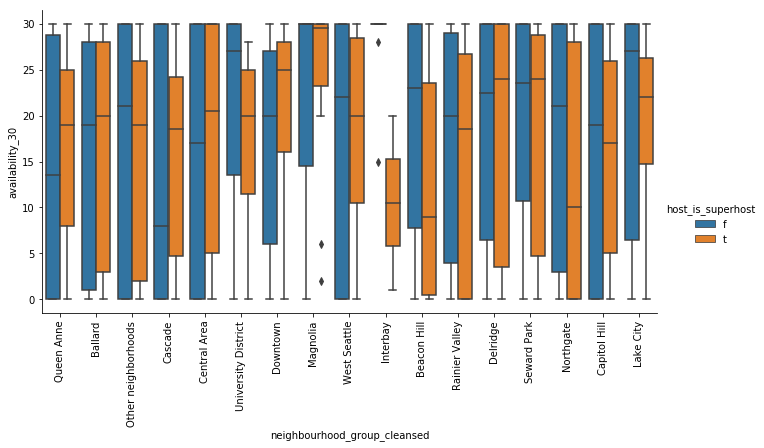

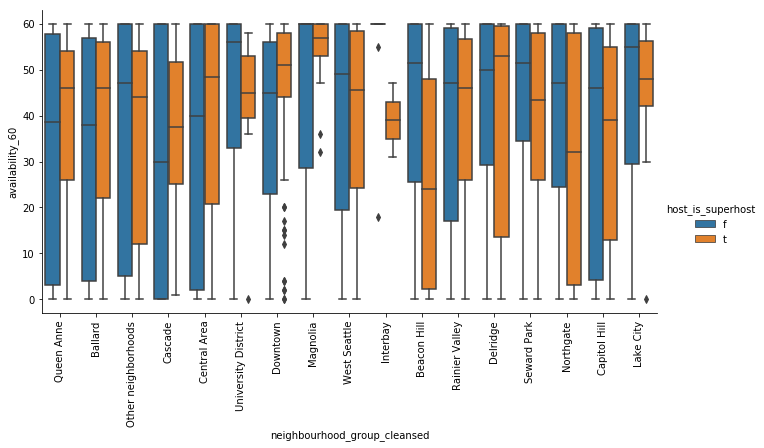

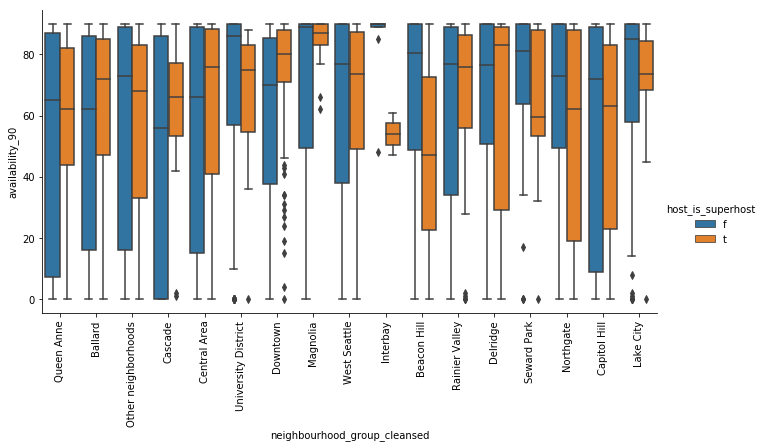

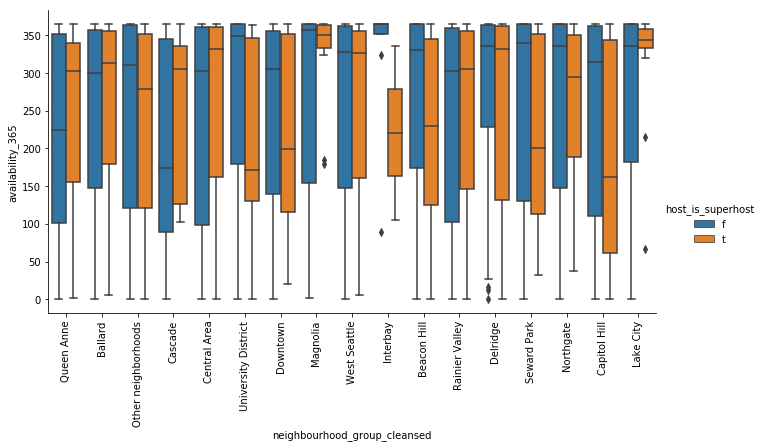

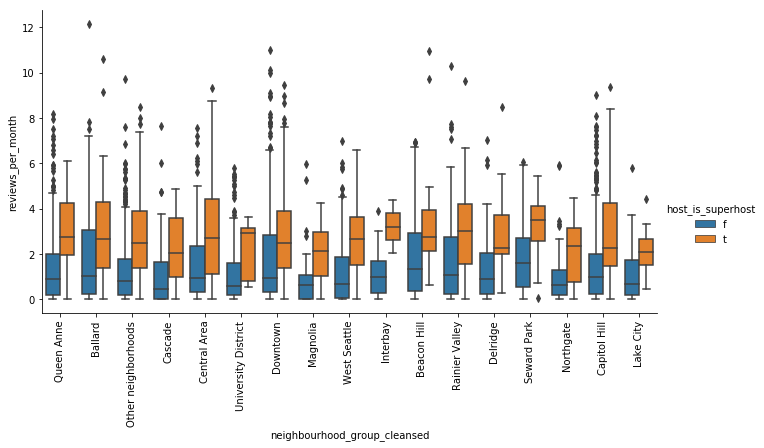

In [125]:
for col in avail_col:
    plot_split('neighbourhood_group_cleansed', col)

From these charts, we can see that future availabilities of superhosts' properties are not consistently lower than that of non-superhosts. However, average number of reviews is consistently higher for superhost properties, which might indicate that superhosts properties have more occupants.
- Superhosts offering one bedrooms, private rooms or shared rooms, or in neighborhoods Capitol Hill or Northgate have consistently lower future availabilities across future months and year.
- However for entire homes, properties of other sizes and those in other neighbourhoods, non-superhosts' properties have less availabilities than superhosts'

In [126]:
def corr_plot(cat_col, df, perc_superhost_df):
    avail_med = df.groupby(["host_is_superhost", cat_col])[avail_col].median().reset_index()
    combo_df = perc_superhost_df.merge(avail_med, left_on = cat_col, right_on = cat_col)
    corr_df = combo_df[combo_df['host_is_superhost']=='t'][avail_col+['perc']].corr()
    sns.heatmap(corr_df)
    return corr_df

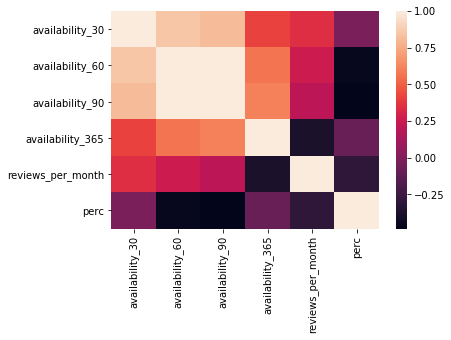

In [127]:
bed_avail_corr = corr_plot('bedrooms', sdf_list_clean, list_super_bednum)

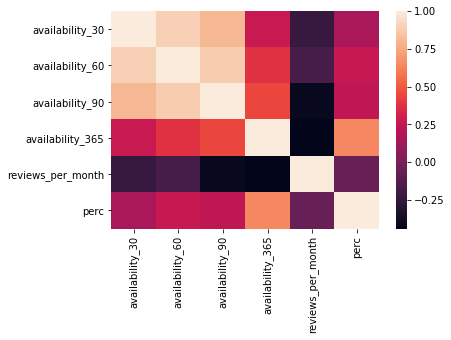

In [128]:
neigh_avail_corr = corr_plot('neighbourhood_group_cleansed', sdf_list_clean, list_super_neigh)

- There are clear correlation between availabilities over the next quarter, however correlation between quarterly and annual availability is much weaker
- Correlation between average number of monthly reviews (past occupancy and reviews) has little to no impact on future availabilities
- Percentage of superhosts in the category also has varying impact on availabilities

In [129]:
def anova_df(data, y, x_cat):
    '''
    Output F-stat, p-value and omega square for variance between superhost dummy variable and y
    INPUT:
    data - df
    y - dependent variable column name. String.
    x_cat - list of independent variable column names that categorise properties. List of strings.
    
    OUTPUT:
    aov - df with statistical summary
    '''
    x_var = [' + '.join(x_cat)][0]
    mod = ols(y + ' ~ host_is_superhost +' + x_var,
                    data=data).fit()
    aov = sm.stats.anova_lm(mod, typ=2)
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))\
                        /(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    return mod, aov

In [130]:
model, aov_avail30 = anova_df(sdf_list_clean, 'availability_30', ['room_type', 'bedrooms', 'neighbourhood_group_cleansed'])
aov_avail30

,sum_sq,df,F,PR(>F),mean_sq,omega_sq
host_is_superhost,195.549062,1.0,1.372723,2.414182e-01,195.549062,0.000094
room_type,11176.134747,2.0,39.227327,1.372443e-17,5588.067374,0.019339
neighbourhood_group_cleansed,10377.438757,16.0,4.552996,3.948634e-09,648.589922,0.014380
bedrooms,659.495027,1.0,4.629548,3.148875e-02,659.495027,0.000918
Residual,540610.770693,3795.0,NaN,NaN,142.453431,NaN


In [131]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        availability_30   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     8.667
Date:                Sun, 18 Aug 2019   Prob (F-statistic):           9.04e-26
Time:                        17:02:46   Log-Likelihood:                -14866.
No. Observations:                3816   AIC:                         2.977e+04
Df Residuals:                    3795   BIC:                         2.991e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              14.9671      0.899     16.650      0.000      13.205      16.730
host_is_superhost[T.t]                                  0.5665      0.484      1.172      0.241      -0.381       1.514
room_type[T.Private room]                               3.5395      0.456      7.770      0.000       2.646       4.433
room_type[T.Shared room]                                5.9906      1.144      5.238      0.000       3.748       8.233
neighbourhood_group_cleansed[T.Beacon Hill]             1.4833      1.355      1.095      0.274      -1.172       4.139
neighbourhood_group_cleansed[T.Capitol Hill]            0.2155      0.942      0.229      0.819      -1.631       2.062
neighbourhood_group_cleansed[T.Cascade]                -2.4268      1.494     -1.624      0.104      -5.356       0.502
neighbourhood_group_cleansed[T.Central Area]           -0.1155      1.003     -0.115      0.908      -2.082       1.851
neighbourhood_group_cleansed[T.Delridge]                2.0431      1.558      1.311      0.190      -1.011       5.097
neighbourhood_group_cleansed[T.Downtown]                2.9125      0.959      3.037      0.002       1.033       4.792
neighbourhood_group_cleansed[T.Interbay]                8.4546      3.685      2.294      0.022       1.229      15.680
neighbourhood_group_cleansed[T.Lake City]               3.7469      1.660      2.258      0.024       0.493       7.001
neighbourhood_group_cleansed[T.Magnolia]                6.9165      1.721      4.020      0.000       3.543      10.290
neighbourhood_group_cleansed[T.Northgate]              -0.2379      1.551     -0.153      0.878      -3.278       2.803
neighbourhood_group_cleansed[T.Other neighborhoods]     0.6642      0.895      0.742      0.458      -1.091       2.419
neighbourhood_group_cleansed[T.Queen Anne]             -0.3424      1.053     -0.325      0.745      -2.406       1.721
neighbourhood_group_cleansed[T.Rainier Valley]          0.5677      1.233      0.460      0.645      -1.850       2.985
neighbourhood_group_cleansed[T.Seward Park]             3.6853      1.964      1.876      0.061      -0.165       7.536
neighbourhood_group_cleansed[T.University District]     4.7068      1.346      3.497      0.000       2.068       7.346
neighbourhood_group_cleansed[T.West Seattle]            2.2455      1.150      1.953      0.051      -0.009       4.500
bedrooms                                               -0.5007      0.233     -2.152      0.031      -0.957      -0.044
==============================================================================
Omnibus:                       49.342   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarqu

**Model results have shown that ANOVA is not the appropriate test to be carried out in this case**

With small sample sizes in each subset of property, and the Jarque Bera p-value being close to zero, the null hypothesis that the data is normally distributed can be rejected. As the data doesn't have a normal distribution, ANOVA cannot be used to test if the two datasets are significantly different, and instead a non-parametric test has to be carried out. Therefore, Kruskal test is adopted instead to investigate whether superhosts and non-superhosts have different levels of availabilities.

In [132]:
def kruskal_test(df_clean, cat1, cat2, cat3, col_compare):
    '''
    Outputs dataframe with p-value for kruskal test of variables between superhost and
    non superhost properties subdivided by categories 1,2 and 3
    '''
    
    kruskal_dict = {cat1:[], 
                   cat2:[],
                   cat3:[]}
    
    for col in col_compare:
        kruskal_dict[col] = []
    
    for cat1_t in df_clean[cat1].unique():
        for cat2_t in df_clean[cat2].unique():
            for cat3_t in df_clean[cat3].unique():

                df = df_clean[(df_clean[cat1]==cat1_t) & (df_clean[cat2]==cat2_t) &
                                   (df_clean[cat3]==cat3_t)]
                kruskal_dict[cat1].append(cat1_t)
                kruskal_dict[cat2].append(cat2_t)
                kruskal_dict[cat3].append(cat3_t)

                df_t = df[df['host_is_superhost']=='t']
                df_f = df[df['host_is_superhost']=='f']

                if (len(df_t)>5) and (len(df_f)>5):
                    for col in col_compare:
                        kruskal_dict[col].append(kruskal(df_t[col], df_f[col]).pvalue)
                else:
                    for col in col_compare:
                        kruskal_dict[col].append(None)
                        
    return pd.DataFrame(kruskal_dict)

In [133]:
pval_avail = kruskal_test(sdf_list_clean, 'room_type', 'bedrooms', 'neighbourhood_group_cleansed', avail_col)
pval_avail.head()

,room_type,bedrooms,neighbourhood_group_cleansed,availability_30,availability_60,availability_90,availability_365,reviews_per_month
0,Entire home/apt,1.0,Queen Anne,0.613687,0.816206,0.591370,0.556188,2.795788e-05
1,Entire home/apt,1.0,Ballard,0.931949,0.406458,0.284161,0.057840,2.173381e-04
2,Entire home/apt,1.0,Other neighborhoods,0.088689,0.108914,0.129298,0.261364,2.086890e-10
3,Entire home/apt,1.0,Cascade,0.012445,0.039778,0.054895,0.361787,1.120559e-02
4,Entire home/apt,1.0,Central Area,0.122261,0.178634,0.177162,0.938404,1.363735e-04


In [134]:
def color_null_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values that can reject null hypothesis
    """
    color = 'red' if val <0.05 else 'black'
    return 'color: %s' % color

pval_avail[~pd.isnull(pval_avail['availability_30'])]\
.style.applymap(color_null_red, subset = avail_col)

,room_type,bedrooms,neighbourhood_group_cleansed,availability_30,availability_60,availability_90,availability_365,reviews_per_month
0,Entire home/apt,1,Queen Anne,0.613687,0.816206,0.59137,0.556188,2.79579e-05
1,Entire home/apt,1,Ballard,0.931949,0.406458,0.284161,0.0578404,0.000217338
2,Entire home/apt,1,Other neighborhoods,0.0886886,0.108914,0.129298,0.261364,2.08689e-10
3,Entire home/apt,1,Cascade,0.0124452,0.0397783,0.0548954,0.361787,0.0112056
4,Entire home/apt,1,Central Area,0.122261,0.178634,0.177162,0.938404,0.000136374
6,Entire home/apt,1,Downtown,0.0184966,0.0112652,0.00373398,0.265606,1.8638e-05
8,Entire home/apt,1,West Seattle,0.780999,0.878142,1,0.659289,0.0222959
11,Entire home/apt,1,Rainier Valley,0.652775,0.814868,0.815085,0.830433,0.00344748
14,Entire home/apt,1,Northgate,0.952413,0.857915,0.857915,0.636144,0.679447
15,Entire home/apt,1,Capitol Hill,0.749909,0.487965,0.500529,0.595522,0.000429573


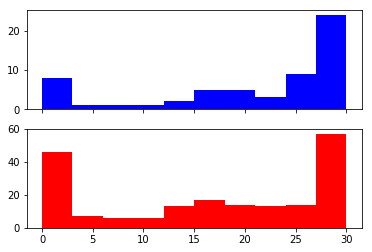

In [135]:
df_hist_plot = sdf_list_clean[(sdf_list_clean['room_type']=='Entire home/apt') & (sdf_list_clean['bedrooms']==1) &
                               (sdf_list_clean['neighbourhood_group_cleansed']=='Downtown')]

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True)
ax1.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='t']['availability_30'], color = 'blue')
ax2.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='f']['availability_30'], color = 'red')
plt.show()

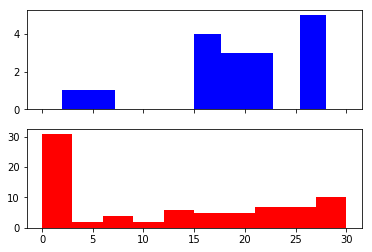

In [136]:
df_hist_plot = sdf_list_clean[(sdf_list_clean['room_type']=='Entire home/apt') & (sdf_list_clean['bedrooms']==0) &
                               (sdf_list_clean['neighbourhood_group_cleansed']=='Downtown')]

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True)
ax1.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='t']['availability_30'], color = 'blue')
ax2.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='f']['availability_30'], color = 'red')
plt.show()

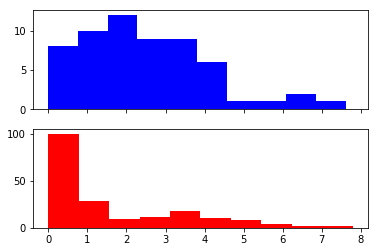

In [137]:
df_hist_plot = sdf_list_clean[(sdf_list_clean['room_type']=='Entire home/apt') & (sdf_list_clean['bedrooms']==1) &
                               (sdf_list_clean['neighbourhood_group_cleansed']=='Downtown')]

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True)
ax1.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='t']['reviews_per_month'], color = 'blue')
ax2.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='f']['reviews_per_month'], color = 'red')
plt.show()

As seen from the Kruskal test above, the availability of most superhosts and non-superhosts properties are not statistically different over the next few months and the next year, after controlling for property types and neighbourhoods. For the few neighbourhood and property types, e.g. Entire homes of one-bedroom and studios in Downtown area, where the p-values have been highlighted in red, it means that non superhosts' properties have statistically lower availabilities than superhosts' over a future three-month period. In some subsets, it could also be because of the unrepresentatively small superhost population. In other words, it cannot be concluded that the superhost status offers you a higher booking rate for the future months and year. 

However, superhosts do get statistically more reviews per month across the board. It could be because they have more last minute bookings that do not show up in the future availability data, have more short stay guests, or simply because their guests are more likely to leave reviews. It is also not conclusive whether superhosts have higher occupancy from this variable

### Question 2. Are superhosts' properties priced higher than non-superhosts? For properties in the same neighbourhood and of similar size, how does price compare?

Similar to the above, box plots will first be plotted to visually understand whether the distribution of prices, controlling other property type variables, are different or not. Then a Kruskal test, instead of a parametric ANOVA (as data is not normally distributed), will be carried out to verify which types of properties exhibit a significantly different price between superhost and non-superhost properties.

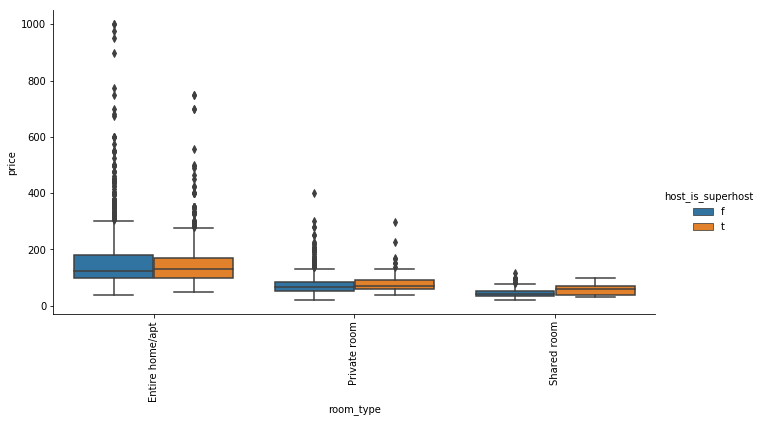

In [138]:
plot_split('room_type', 'price')

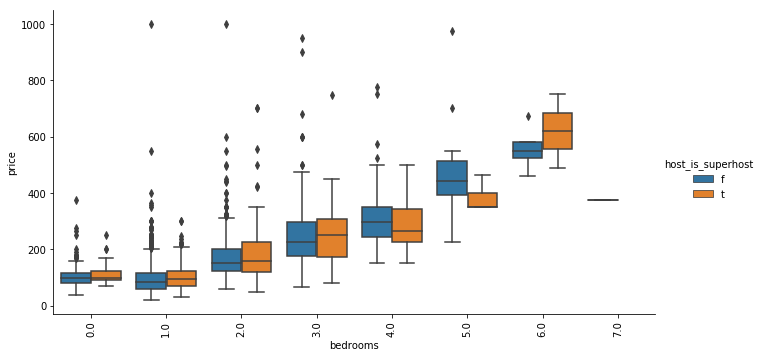

In [139]:
plot_split('bedrooms', 'price')

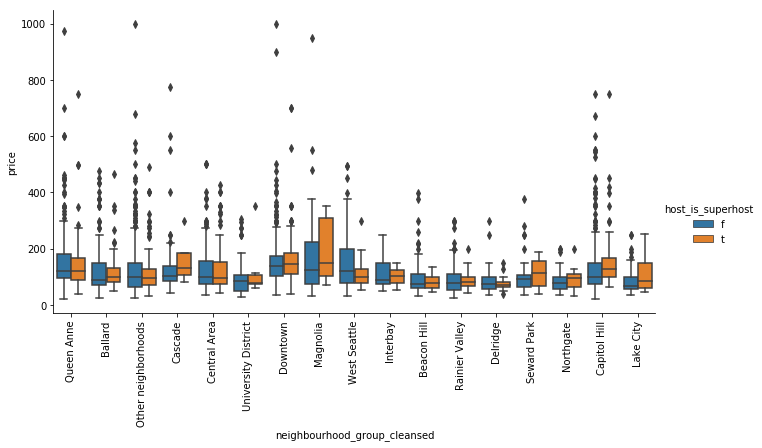

In [140]:
plot_split('neighbourhood_group_cleansed', 'price')

From the above box plots, it can be seen that superhosts and non-superhosts price their properties at a similar range for different property types and neighbourhoods. Kruskal test is carried out below to further investigate this.

In [141]:
pval_price = kruskal_test(sdf_list_clean, 'room_type', 'bedrooms', 'neighbourhood_group_cleansed', ['price'])
pval_price.head()

,room_type,bedrooms,neighbourhood_group_cleansed,price
0,Entire home/apt,1.0,Queen Anne,0.248369
1,Entire home/apt,1.0,Ballard,0.268962
2,Entire home/apt,1.0,Other neighborhoods,0.576512
3,Entire home/apt,1.0,Cascade,0.081161
4,Entire home/apt,1.0,Central Area,0.283478


In [142]:
pval_price[~pd.isnull(pval_price['price'])]\
.style.applymap(color_null_red, subset = ['price'])

,room_type,bedrooms,neighbourhood_group_cleansed,price
0,Entire home/apt,1,Queen Anne,0.248369
1,Entire home/apt,1,Ballard,0.268962
2,Entire home/apt,1,Other neighborhoods,0.576512
3,Entire home/apt,1,Cascade,0.0811613
4,Entire home/apt,1,Central Area,0.283478
6,Entire home/apt,1,Downtown,0.0864463
8,Entire home/apt,1,West Seattle,0.0659102
11,Entire home/apt,1,Rainier Valley,0.337853
14,Entire home/apt,1,Northgate,0.0323129
15,Entire home/apt,1,Capitol Hill,0.102441


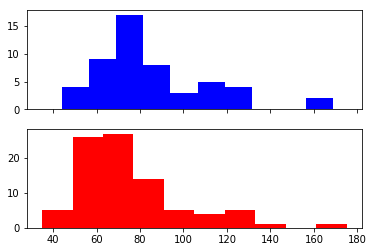

In [143]:
df_hist_plot = sdf_list_clean[(sdf_list_clean['room_type']=='Private room') & (sdf_list_clean['bedrooms']==1) &
                               (sdf_list_clean['neighbourhood_group_cleansed']=='Central Area')]

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True)
ax1.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='t']['price'], color = 'blue')
ax2.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='f']['price'], color = 'red')
plt.show()

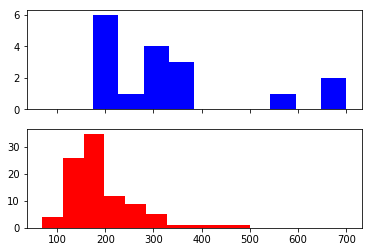

In [144]:
df_hist_plot = sdf_list_clean[(sdf_list_clean['room_type']=='Entire home/apt') & (sdf_list_clean['bedrooms']==2) &
                               (sdf_list_clean['neighbourhood_group_cleansed']=='Downtown')]

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex = True)
ax1.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='t']['price'], color = 'blue')
ax2.hist(df_hist_plot[df_hist_plot['host_is_superhost']=='f']['price'], color = 'red')
plt.show()

The Kruskal test result (from the above table) shows that only 36 property-type neighbourhood combinations have enough samples for testing. And only 8 of which show significant price difference between superhosts' and non-superhosts' properties. In these subsets, superhosts price their property higher than non-superhosts on average. Therefore, it is inconclusive as to whether superhosts price their properties higher than non-superhosts as a whole. 

### Question 3. What are the top 10 factors affecting occupancy rate?

From the above EDA, we can see that the distribution of availability variables are very skewed towards both the lower and higher end. Therefore, to carry out this analysis, we have to transform the dependent variables. To avoid complex log transformations, I would transform the 'availability_30', '..._60' and '..._90' variables into various classes - high, medium and low availabilities. It is also because for the purpose of this analysis, precision (in terms of days of availability) is not required and it is more focused on the directional indications of important variables.

A classification model will then be fitted. Gradient boosting classifier and random forest classifier are chosen as both models can compute the feature importance, which would help answer the question.

In [145]:
def cov_categories(df):
    '''
    Converts any continuous numerical columns into categorical - 
    lowest quartile is 'low', highest quartile is 'high',
    otherwise 'medium'
    '''
    col_list = df.columns
    for col in col_list:
        low_per = np.percentile(df[col], 25)
        high_per = np.percentile(df[col], 75)
        df['cov_'+col] = df[col].apply(lambda x: 'low' if x<=low_per 
                                       else 'high' if x>=high_per
                                      else 'med')
        
    df_new = df.drop(col_list, axis = 1)
    
    return df_new

In [146]:
X = sdf_list_feat.drop(avail_col[:4], axis = 1)
y = sdf_list_feat.loc[:,avail_col[:4]]
y_cov = cov_categories(y)
y_cov.head()

,cov_availability_30,cov_availability_60,cov_availability_90,cov_availability_365
0,med,med,med,med
1,med,low,low,med
2,low,low,low,med
3,low,low,low,med
4,high,high,high,high


In [147]:
def stratfold_model(X, y, model):
    '''
    Return trained model and scoring after training specified model using stratefied Kfold
    '''
    
    skf = StratifiedKFold(n_splits=5)
    test_result = pd.DataFrame()
    
    for train_index, test_index in skf.split(X, y.iloc[:,0]):

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

        # Scale and reduce dimensions on training data before fitting model
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        mo_reg = model
        mo_reg.fit(X_train_scaled, y_train)
        y_train_pred = mo_reg.predict(X_train_scaled)
        y_train_acc = (y_train_pred == y_train).sum()/len(y_train_pred)

        X_test_scaled = scaler.transform(X_test)
        y_test_pred = mo_reg.predict(X_test_scaled)
        y_test_acc = (y_test_pred == y_test).sum()/len(y_test_pred)
        
        print("TRAIN Acc:", y_train_acc, "TEST Acc:", y_test_acc)
        print(" ")
        
        y_acc = pd.concat([y_train_acc, y_test_acc], axis = 1)
        y_acc['model'] = str(mo_reg)
        
        test_result = pd.concat([test_result, y_acc], axis = 0, ignore_index = True)
        
    return X_train_scaled, y_train_pred, y_test_pred, test_result, mo_reg

In [148]:
estimators = [RandomForestClassifier(max_depth = 80, min_samples_split = 50), 
              RandomForestClassifier(max_depth = 50, min_samples_split = 30),
              GradientBoostingClassifier(max_depth = 50, min_samples_split = 30, subsample = 0.7),
              GradientBoostingClassifier(max_depth = 80, min_samples_split = 50, subsample = 0.7)]

eval_result = pd.DataFrame()
for est in estimators:
    print(est)
    X_train, y_train_pred, y_test_pred, result, mo_reg = \
    stratfold_model(X, y_cov, MultiOutputClassifier(estimator = est))
    eval_result = pd.concat([result, eval_result], axis = 0, ignore_index = True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
TRAIN Acc: cov_availability_30     0.702163
cov_availability_60     0.711009
cov_availability_90     0.684142
cov_availability_365    0.680210
dtype: float64 TEST Acc: cov_availability_30     0.556136
cov_availability_60     0.549608
cov_availability_90     0.567885
cov_availability_365    0.514360
dtype: float64
 
TRAIN Acc: cov_availability_30     0.694599
cov_availability_60     0.700818
cov_availability_90     0.706056
cov_availability_365    0.667103
dtype: float64 TEST Acc: cov_availability_30     0.568807
cov_availability_60     0.591088
cov_availability_90   

The gradient boosting classifier with max depth of 80 and minimum samples split of 50 has achieved the highest test accuracy amongst the three chosen models of around 58% for all four variables, with the other gradient boosting model with different hyperparameters coming close second. Random forest classifier comes last at around 55%

There is overfitting across all models, as other models also show significantly higher accuracy in training set. Gradient boosting methods give high accuracy for training set, at almost 100%. Therefore random forest model with a higher maximum depth and minimum samples split is chosen instead.

In [149]:
X_train, y_train_pred, y_test_pred, rf_result, mo_reg = stratfold_model(X, y_cov, MultiOutputClassifier(\
                                                     estimator = RandomForestClassifier(\
                                                     max_depth = 80, min_samples_split = 50)))

TRAIN Acc: cov_availability_30     0.701507
cov_availability_60     0.698886
cov_availability_90     0.711664
cov_availability_365    0.671363
dtype: float64 TEST Acc: cov_availability_30     0.545692
cov_availability_60     0.519582
cov_availability_90     0.540470
cov_availability_365    0.536554
dtype: float64
 
TRAIN Acc: cov_availability_30     0.693617
cov_availability_60     0.702782
cov_availability_90     0.694599
cov_availability_365    0.677250
dtype: float64 TEST Acc: cov_availability_30     0.570118
cov_availability_60     0.576671
cov_availability_90     0.608126
cov_availability_365    0.533421
dtype: float64
 
TRAIN Acc: cov_availability_30     0.691980
cov_availability_60     0.706056
cov_availability_90     0.703110
cov_availability_365    0.668412
dtype: float64 TEST Acc: cov_availability_30     0.547837
cov_availability_60     0.557012
cov_availability_90     0.574050
cov_availability_365    0.536042
dtype: float64
 
TRAIN Acc: cov_availability_30     0.701800
cov_a

In [150]:
def feat_imp_avail(day):
    day_list = [30, 60, 90, 365]
    index = day_list.index(day)
    feat_imp_df = pd.DataFrame(mo_reg.estimators_[index].feature_importances_, index = X.columns)\
    .sort_values(ascending = False, by = 0).head(10)
    
    return feat_imp_df

In [165]:
def feat_imp_chart(day):
    plt.bar(np.arange(10), feat_imp_avail(day)[0])
    plt.xticks(np.arange(10), labels = feat_imp_avail(day).index, rotation = 'vertical')
    plt.show()

In [151]:
# features related to future 30-day availability

feat_imp_avail(30)

,0
reviews_per_month,0.133787
last_review,0.105317
number_of_reviews,0.055292
first_review,0.043936
clean_price,0.027727
host_since,0.027021
amenities,0.023027
review_scores_rating,0.022990
host_response_rate,0.022283
weekly_disc,0.021539


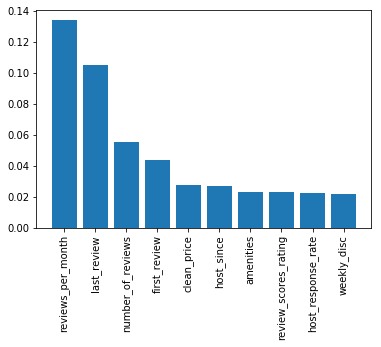

In [166]:
feat_imp_chart(30)

In [152]:
# features related to future 60-day availability

feat_imp_avail(60)

,0
last_review,0.111258
reviews_per_month,0.070079
number_of_reviews,0.069413
host_response_time_within an hour,0.034540
clean_price,0.032179
host_total_listings_count,0.031695
host_since,0.029932
first_review,0.028720
price_per,0.027781
weekly_disc,0.020338


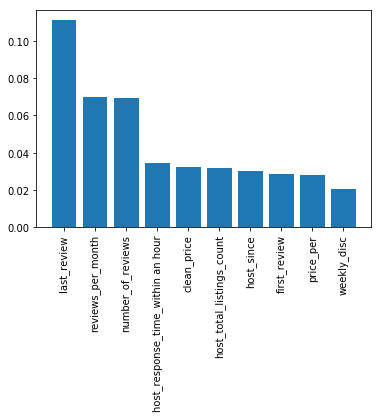

In [167]:
feat_imp_chart(60)

In [153]:
# features related to future 90-day availability

feat_imp_avail(90)

,0
last_review,0.084938
number_of_reviews,0.075975
reviews_per_month,0.050760
host_since,0.038328
host_total_listings_count,0.035904
host_response_time_within an hour,0.033659
host_response_rate,0.031299
price_per,0.029639
weekly_disc,0.029369
first_review,0.028982


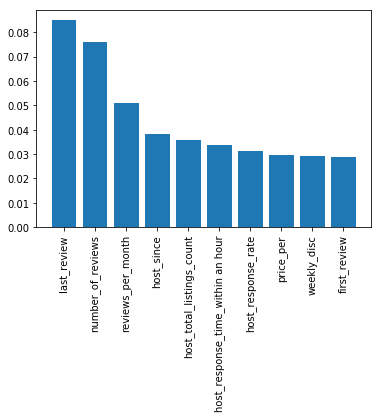

In [168]:
feat_imp_chart(90)

In [154]:
# features related to future 365-day availability

feat_imp_avail(365)

,0
number_of_reviews,0.045040
host_total_listings_count,0.040244
host_since,0.036860
last_review,0.036856
reviews_per_month,0.034546
amenities,0.033550
clean_price,0.032927
first_review,0.032703
price_per,0.029975
weekly_disc,0.028530


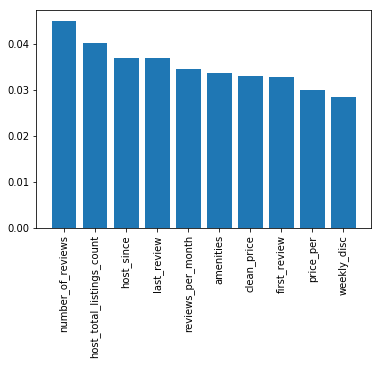

In [169]:
feat_imp_chart(365)

From the above feature importance table, we can see that the most important determinants are in one of the following buckets:
- Past review frequency and timing (reviews_per_month, last_review)
- Price (price_per, weekly_disc, clean_price, monthly_disc)
- Response time and rate (host_response_within an hour, host_response_rate)
- When the host has started hosting (host_since, first_review)

All of the above factors makes sense in context. The number of past reviews and their recency are related to how popular the property has been in the recent past, and hence will give new guests greater confidence in the property. Similarly this also explains why duration of hosting (when the host has started hosting) is a top factor. As a host joins airbnb for longer, they are likely to have more bookings, and hence more past reviews to indicate that they are reliable. 

Price is another major factor, given that the majority of airbnb customers are likely to be price conscious (airbnb price are likely to be lower than hotels). Therefore, price per guest, long-stay discounts, and cleaning costs often appear on the top list. In addition, the number of amenities provided is an important factor, for example, some are likely to book properties that provide parking, washing machine or kitchen.

## 5. Evaluation

From the above analysis results, questions posed in the beginning are concluded here and necessary improvements suggested.  

##### Question 1. Are superhosts' properties more occupied (lower future occupancy) than non-superhosts'?

Controlling for property types (room type, size) and neighbourhoods, there is no evident to show that superhosts' properties are more occupied than those of non-superhosts. There are even 9 property-neighbourhood types where non-superhosts' properties show higher booking rate than that of superhosts. It can be seen from some of the box plots as well as Kruskal test result that show statistically significant test results.

However there are still a few limitations in the analysis:
- There is insufficient data points for a majority of property-neighbourhood types, e.g. some of them have fewer than 5 superhost properties. As such, statistical analysis cannot be carried out and conclusion cannot be drawn for those subsets.
- In most neighbourhoods there are much more non-superhosts than superhosts. Therefore, superhosts data might be less representative than that of non-superhosts.

To mitigate the above, panel data can be obtained and analysed. We can then understand if the data here only represents a point in time or if it is representative of the status quo. We can also conduct regression or classification modelling, including the property types and superhost status as variables, to understand their respective strength. 

##### Question 2. Are superthosts' properties priced higher than non-superhosts?

Controlling for the same property variables as above, there are only statistically significant price differences (p-value < 0.05) between superhosts and non-superhosts in only 8 of the 36 property types (in neighbourhoods) that have sufficient samples. In these places, superhosts charge more than non-superhosts on average, as seen from the Kruskal test and histogram.

The limitations of data insufficiency and relevant mitigation methods are similar as above.

##### Question 3. What are the top 10 factors affecting occupancy rate?

The top ten factors vary slightly depending on whether availability prediction is for the near future or in a year's time. Nevertheless, top factors are past review frequency and timing (reviews_per_month, last_review), price (price_per, weekly_disc, clean_price, monthly_disc), and when the host has started hosting (host_since, first_review).

Most of the top factors are continuous variables. This could have reflected the top factors are genuinely the top factors. It could also be because the tfidf transformations results in a sparse matrix, and hence other binary factors are not identified. Another issue is that some of the variables could be highly correlated. 

One of the improvements could be to reduce the dimensions before fitting the model. Also, we could also find out the correlation coefficient between different variables. For those that are highly correlated, one of the pair has to be removed.
